In [15]:
from __future__ import annotations
import zipfile
import pandas as pd
import os
from io import StringIO
import matplotlib.pyplot as plt
import math

In [70]:
MAIN_DIR = "/Users/alex/Desktop/CS/Internships and Research/DBF/python_tools/data/thrustStand/10_22_2023"
THRUST_ZIP = MAIN_DIR + "/throttle_percent.zip"
RPM_FILE = "/Users/alex/Desktop/CS/Internships and Research/DBF/python_tools/data/thrustStand/PER2_RPMRANGE.DAT"

In [82]:
with open(RPM_FILE, "r") as f:
    rpm_range = f.readlines()
    rpm_range = rpm_range[rpm_range.index('APC Prop                                 Min       Max\n') + 1:]
    rpm_range = list(map(lambda x: x.split(), rpm_range))
    rpm_range = {x[0]: (int(x[1]), int(x[2])) for x in rpm_range}
    print(rpm_range)

{'105x45': (1000, 23000), '105x6': (1000, 20000), '10x10': (1000, 19000), '10x10E': (1000, 19000), '10x12WE': (1000, 20000), '10x3': (1000, 22000), '10x38MRF-RH': (1000, 23000), '10x38SF': (1000, 23000), '10x4': (1000, 21000), '10x45MR': (1000, 22000), '10x45MRF-RH': (1000, 24000), '10x46SF': (1000, 23000), '10x47SF': (1000, 23000), '10x5': (1000, 20000), '10x55MR': (1000, 22000), '10x58EP(F2B)': (1000, 21000), '10x5E': (1000, 21000), '10x6-4': (1000, 22000), '10x6': (1000, 20000), '10x6E': (1000, 21000), '10x6F': (1000, 20000), '10x7': (1000, 22000), '10x7E': (1000, 21000), '10x7SF': (1000, 22000), '10x8': (1000, 20000), '10x8E': (1000, 21000), '10x9': (1000, 19000), '115x4': (1000, 20000), '115x6': (1000, 18000), '11x10': (1000, 18000), '11x10E': (1000, 18000), '11x11': (1000, 21000), '11x12': (1000, 20000), '11x12E': (1000, 18000), '11x12W': (1000, 20000), '11x13': (1000, 20000), '11x14': (1000, 19000), '11x3': (1000, 20000), '11x38SF': (1000, 21000), '11x4': (1000, 19000), '11x45EP

Reading throttle_percent/AT7215_16x10x3_12s.csv
Average ratio: 1.2288520263911797


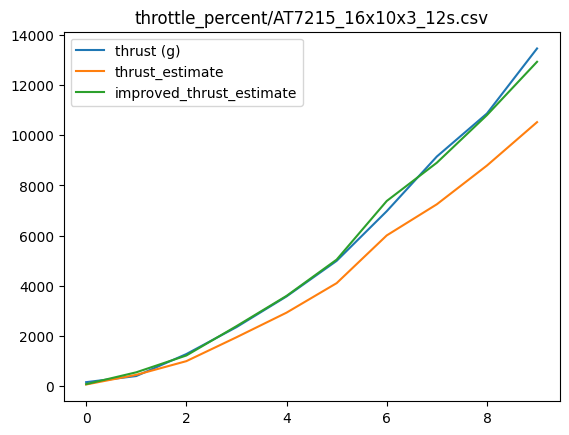

Reading throttle_percent/AT7215_14x13x3_12s.csv
Average ratio: 1.5080132153180432


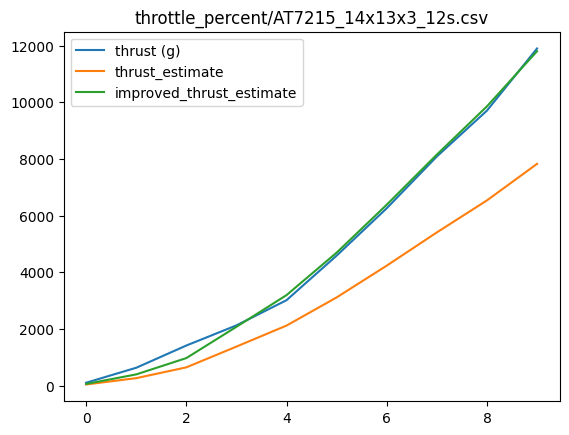

Reading throttle_percent/AT7215_18x14_12s.csv
Average ratio: 0.8051535917770886


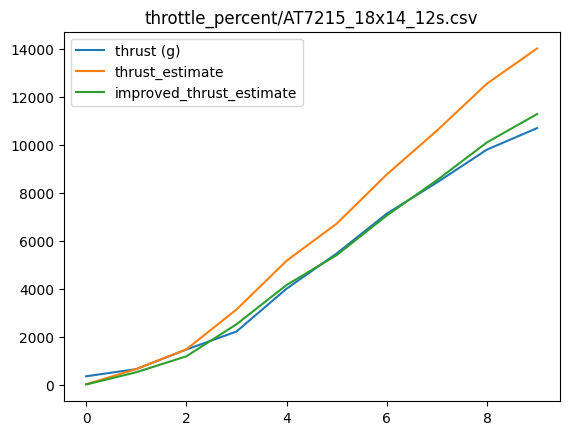

Reading throttle_percent/AT7215_16x14XOR_12s_Run_3.csv
Average ratio: 0.8928471383701496


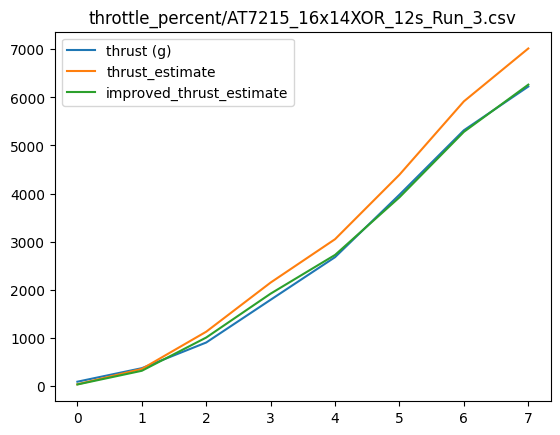

Reading throttle_percent/AT7215_19x10_12s.csv
Average ratio: 0.9936726821788052


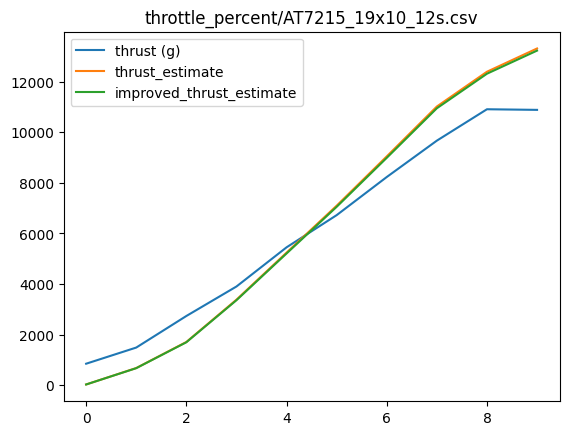

Reading throttle_percent/AT7215_16x16_8s.csv
Average ratio: 0.9036401124914727


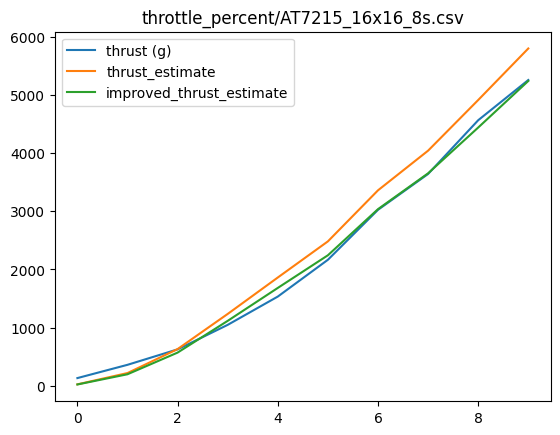

Reading throttle_percent/AT7215_15x14x3_12s.csv
Average ratio: 1.3488937498726874


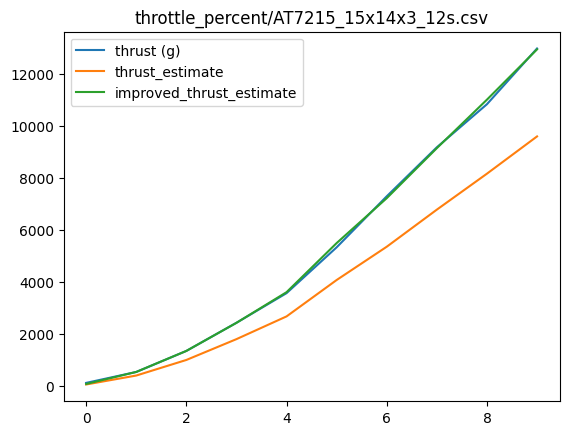

Reading throttle_percent/AT7215_16x12_12s.csv
Average ratio: 0.9090228590626505


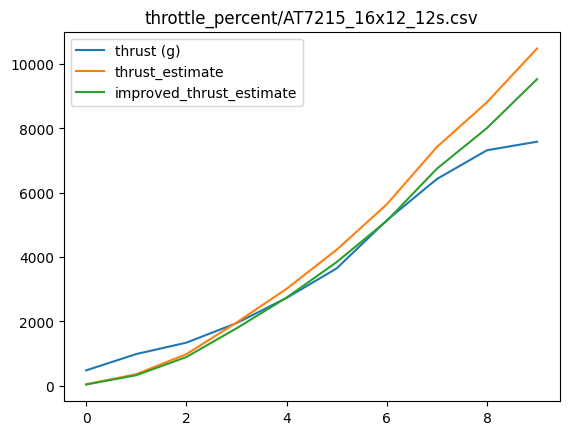

Reading throttle_percent/AT7215_17x12_8s.csv
Average ratio: 0.9182747109070017


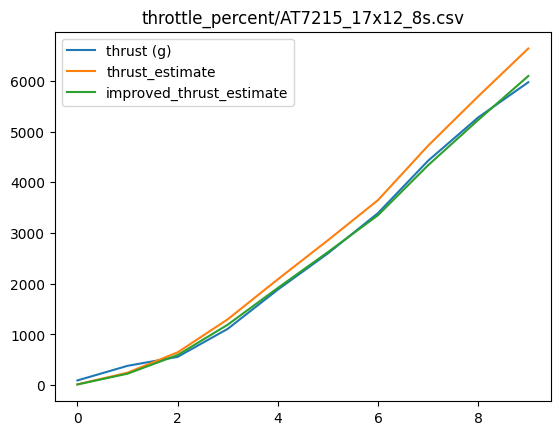

Reading throttle_percent/AT5330_16x10x3_12s.csv
Average ratio: 1.3104700007479055


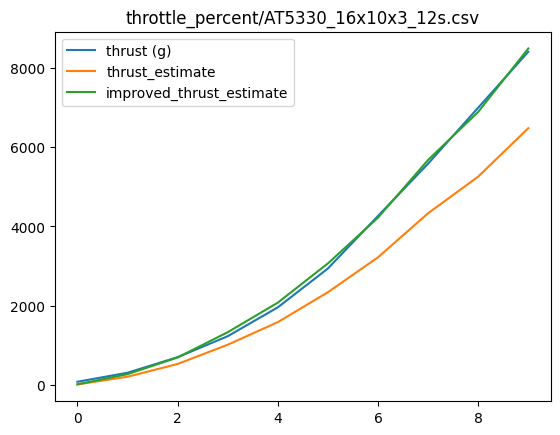

Reading throttle_percent/AT7215_18x12_12s.csv
Average ratio: 0.9170695866314551


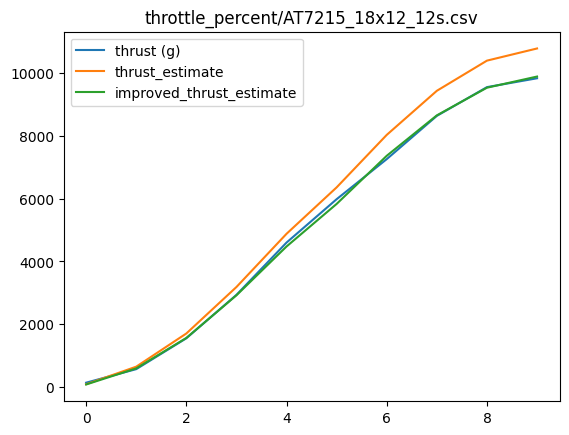

Reading throttle_percent/AT7215_16x16_12s.csv
Average ratio: 0.9180326863186591


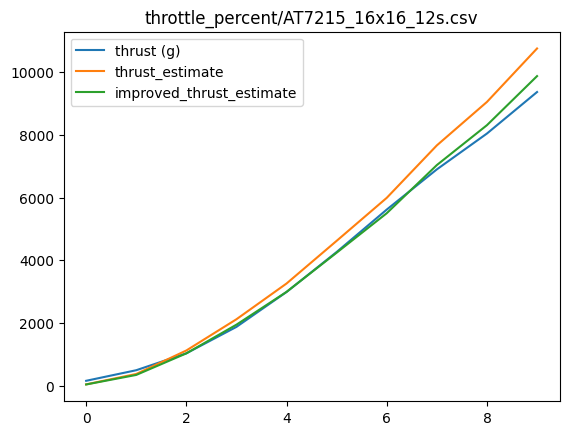

Reading throttle_percent/AT7215_15x13.5x3_12s.csv
Average ratio: 1.1873808711392422


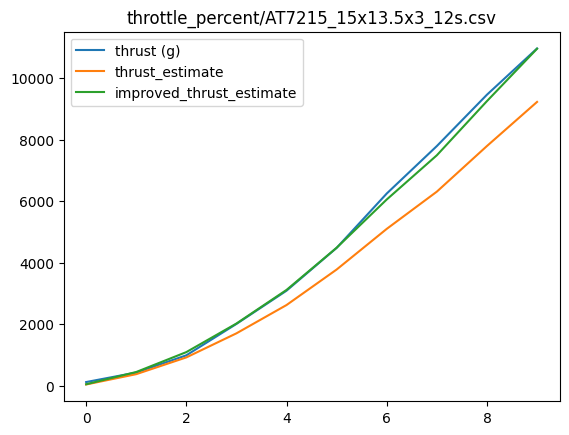

Reading throttle_percent/AT5330_14x13x3_12s.csv
Average ratio: 1.64805252961174


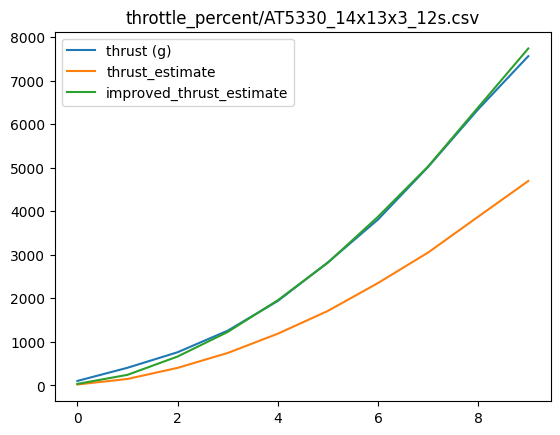

Reading throttle_percent/AT7215_16x14_12s.csv
Average ratio: 0.954008170771368


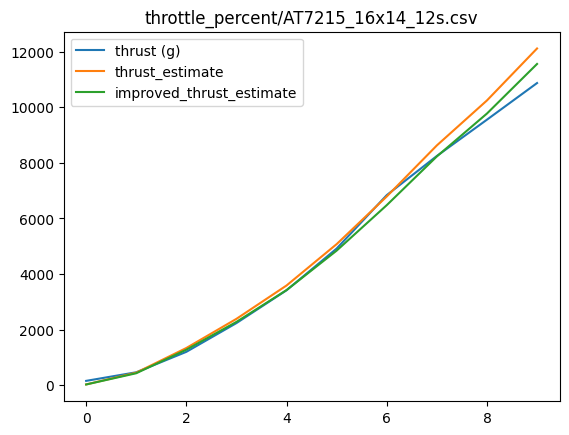

Reading throttle_percent/AT7215_17x12_12s.csv
Average ratio: 0.8739975668559941


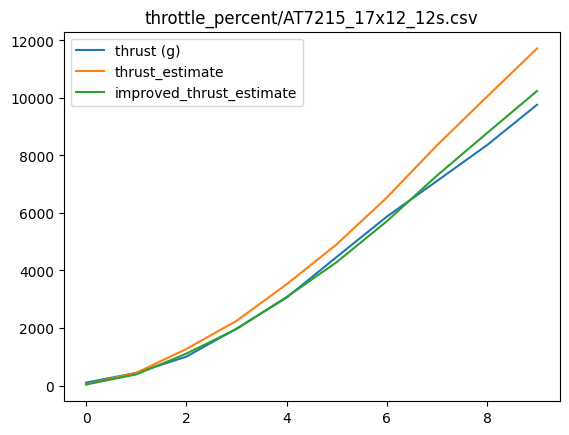

Reading throttle_percent/AT5330_15x14x3_12s.csv
Average ratio: 1.5427696740156605


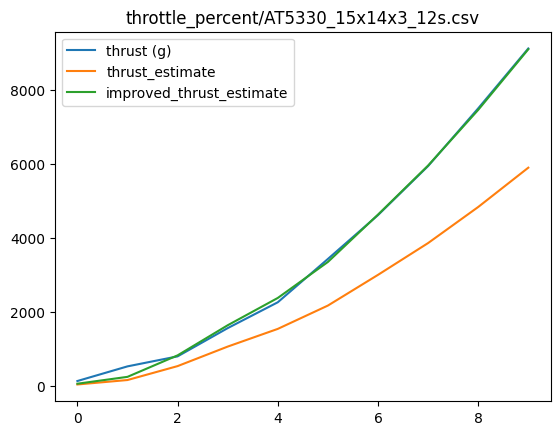

In [85]:
thrs = dict()
thrs["velocity (mph)"] = [i for i in range(30, 45)]
with zipfile.ZipFile(THRUST_ZIP) as z:
    for name in z.namelist():
        if not name.endswith('.csv') or name.startswith('_'):
            continue
        print("Reading {}".format(name))
        data = z.read(name)
        df = pd.read_csv(StringIO(data.decode('utf-8')))
        prop = name.split('_')[2].split('_')[0].replace('XOR', '')
        diameter = float(prop.split('x')[0])
        pitch = float(prop.split('x')[1])
        def estimate_thrust(row):
            rpm = row["correctedRPM"]
            thrust_newton = 1.225 * math.pi * (0.0254 * diameter) ** 2 / 4 * (rpm / 60.0 * 0.0254 * pitch) ** 2
            thrust_newton_empirical = thrust_newton * (diameter / (pitch * 3.29546)) ** 1.5
            return thrust_newton_empirical * 101.9716213
        df["thrust_estimate"] = df.apply(estimate_thrust, axis=1)
        df["actual_estimate_ratio"] = df["thrust (g)"] / df["thrust_estimate"]
        average_ratio = df["actual_estimate_ratio"].median()
        print("Average ratio: {}".format(average_ratio))
        max_rpm = df["correctedRPM"].max() # rpm_range.get(prop, (df["correctedRPM"].max(), 0))[0] 
        df["improved_thrust_estimate"] = df["thrust_estimate"] * average_ratio
        df[['thrust (g)', 'thrust_estimate', 'improved_thrust_estimate']].plot()
        plt.title(name)
        plt.show()

        def dynamic_thrust(velocity):
            rpm = max_rpm
            thrust_newton = 1.225 * math.pi * (0.0254 * diameter) ** 2 / 4 * ((rpm / 60.0 * 0.0254 * pitch) ** 2 - (rpm / 60.0 * 0.0254 * pitch) * velocity)
            thrust_newton_empirical = thrust_newton  * (diameter / (pitch * 3.29546)) ** 1.5 * average_ratio
            return thrust_newton_empirical * 101.9716213
        
        thrusts = [dynamic_thrust(i) / 101.9716213 for i in thrs["velocity (mph)"]]
        thrs[prop] = thrusts

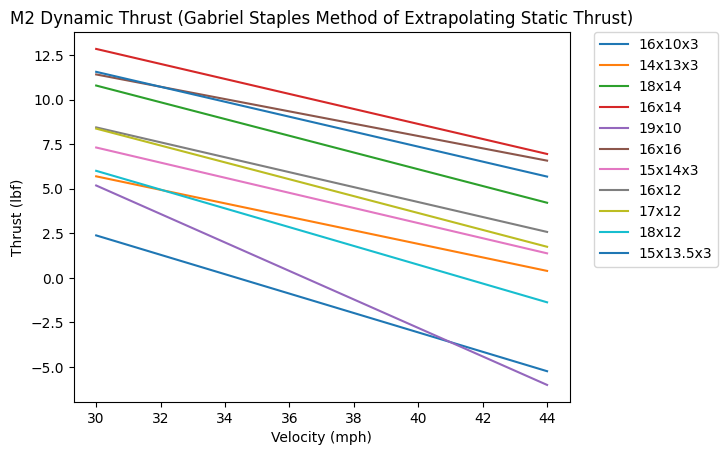

In [86]:
df = pd.DataFrame(thrs)
df = df.set_index("velocity (mph)")
df = df.apply(lambda x: x / 4.44822)
df.plot()
plt.xlabel("Velocity (mph)")
plt.ylabel("Thrust (lbf)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.title("M2 Dynamic Thrust (Gabriel Staples Method of Extrapolating Static Thrust)")
plt.show()